# Photo-z data AugMent (PAM)

#### Setup:

Run `source setup.sh` from `bash` command line in kernel in order to setup paths for code.

## Create train/test catalogs

In [25]:
import os
from create_cats import create_cats
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Create base catalog

In [26]:
# Catalog columns
names = ['redshift', 'u', 'g', 'r', 'i', 'z', 'y']#, 'g_abs', 'r_abs']

In [55]:
# Point to catalog
cat_name = 'buzzard_high-res_2_sq_deg_z_2.csv'
filename = os.path.join(os.environ['PZ_CAT_FOLDER'], cat_name)

Training set size: 500000. Test set size: 1000193.


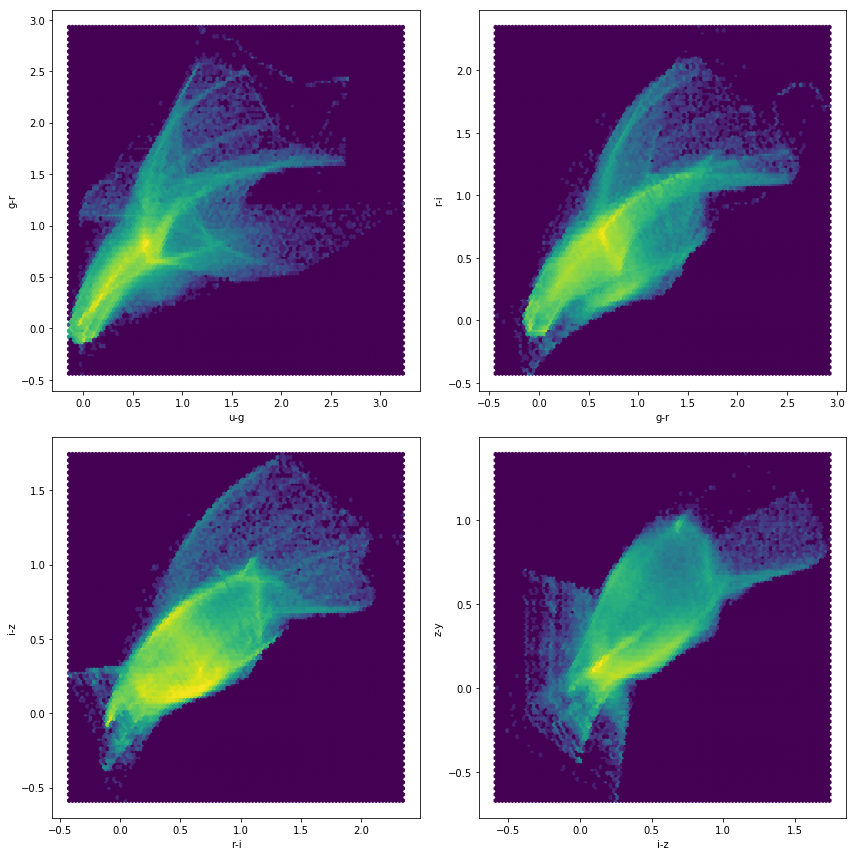

In [56]:
# Create a base train/test catalog with 500,000 objects in training set
# and remaining in test set
cc = create_cats(filename, names)
cc.create_base_cats('full_buzzard', 500000, out_dir='../data', random_state=2136)

### Create alternative catalogs

Training set size: 100000. Test set size: 2497906.


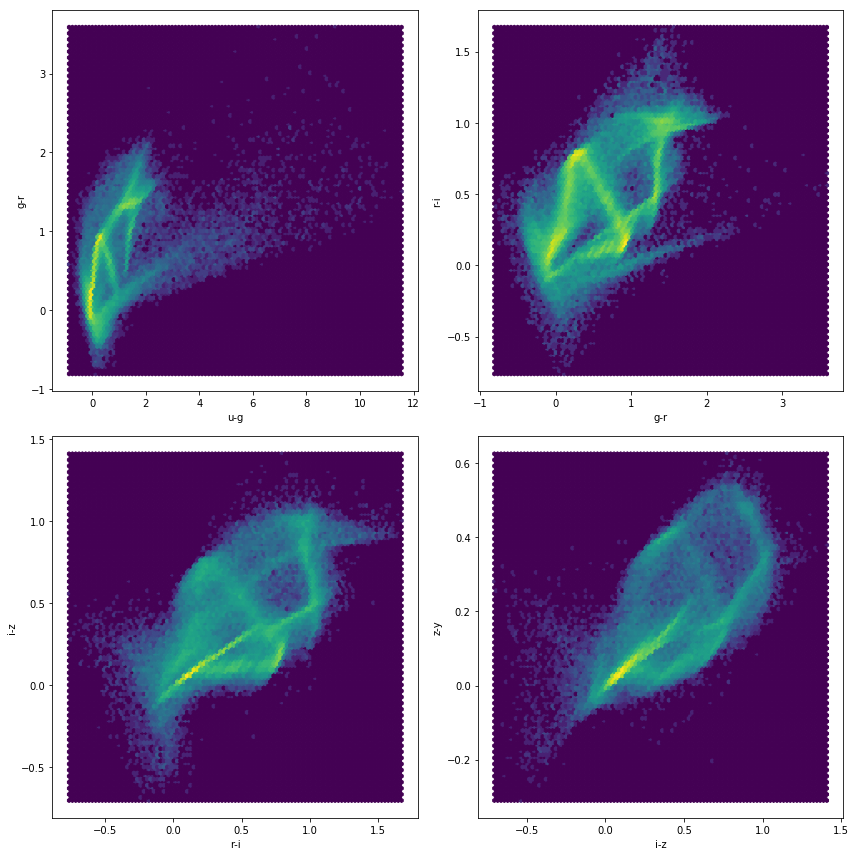

In [5]:
# Sparse catalog, only 100000 training, no color cut, no redshift cut
cc.create_sparse_cats('sparse', 500000, sparsity=5,
                      out_dir='../data')

0 2 500
Training set size: 495406. Test set size: 2497906.


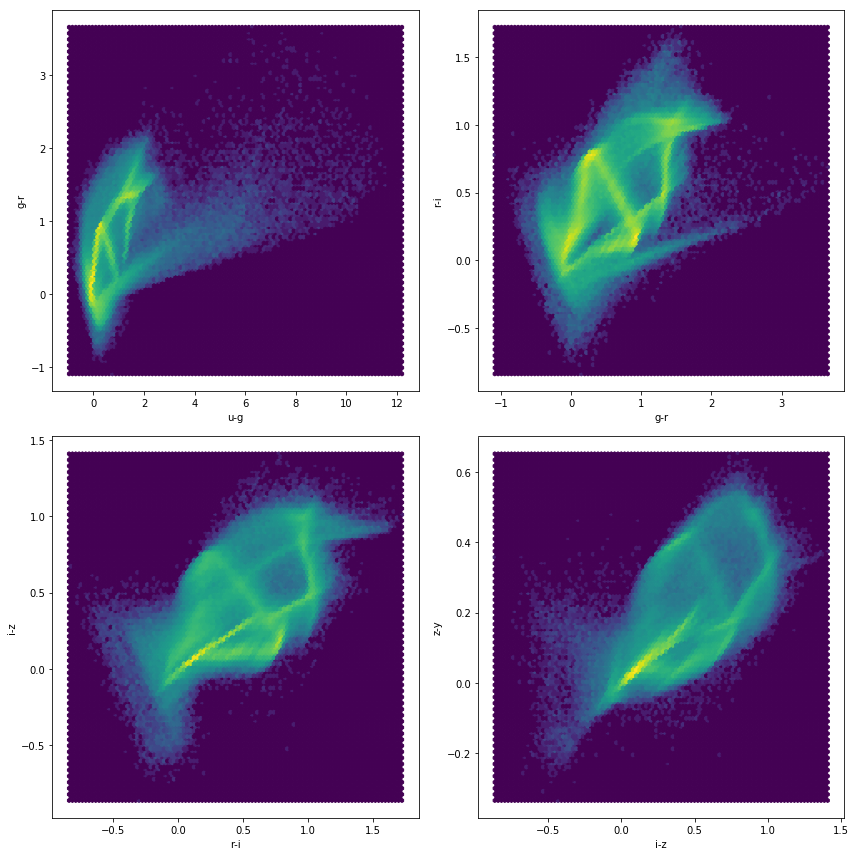

In [8]:
# Red color cut, u-g > 2. reduced by 80%
cc.create_color_cut_cats('ug_color_cut', 500000, [0], [2], [500], 
                         sparsity=[5], out_dir='../data')

Training set size: 466328. Test set size: 2497906.


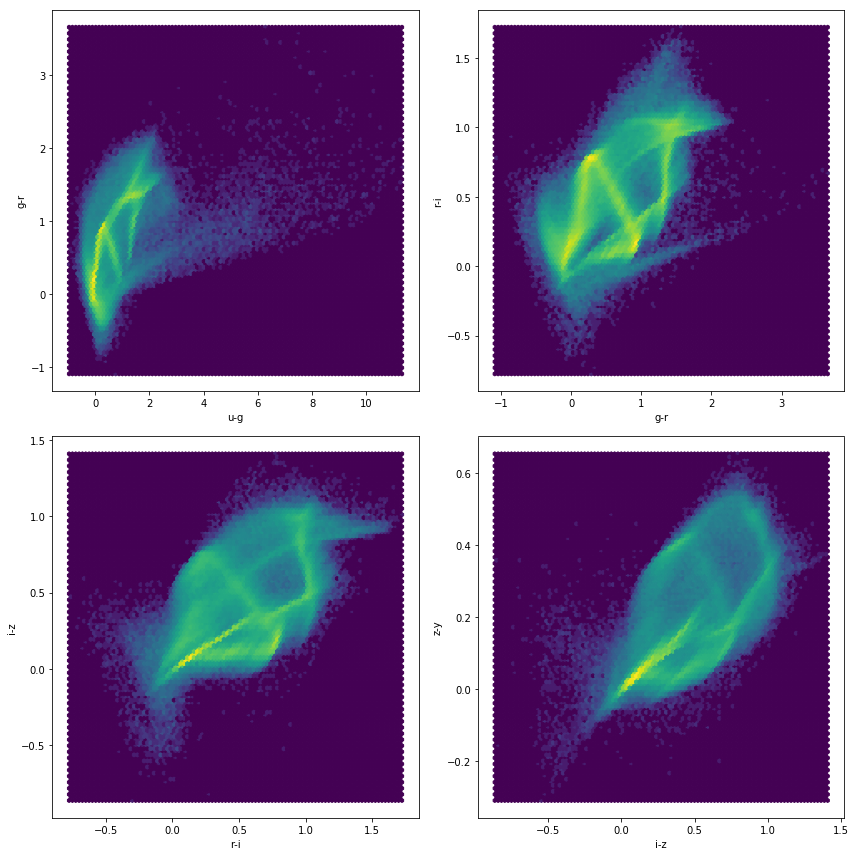

In [10]:
# Redshift cut, z > 2. reduced by 80%
cc.create_redshift_cut_cats('z_2_cut', 500000, 2.0, 5.0, sparsity=4,
                            out_dir='../data')

## Train networks

In [16]:
import pandas as pd
from photoz_nn import photoz_nn

In [ ]:
for cat_suffix in ['full']:#, 'sparse', 'ug_color_cut', 'z_2_cut']:
    
    print(cat_suffix)
    pz_nn = photoz_nn(seed=1446)

    train_filename = '../data/train_cat_%s.dat' % cat_suffix
    train_colors, train_specz = pz_nn.load_catalog(train_filename)
    test_filename = '../data/test_cat_%s.dat' % cat_suffix
    test_colors, test_specz = pz_nn.load_catalog(test_filename)

    train_len = len(train_colors)
    test_len = len(test_colors)

    net = pz_nn.train_model(train_colors, train_specz, 500)

    train_photoz = pz_nn.run_model(net, train_colors)
    test_photoz = pz_nn.run_model(net, test_colors)

    pz_nn.save_model(net, '../data/pz_network_%s.pt' % cat_suffix)

    train_results = {'true_z':train_specz.reshape(train_len),
                     'photo_z': train_photoz.reshape(train_len)}
    train_results_df = pd.DataFrame.from_dict(data=train_results)
    test_results = {'true_z':test_specz.reshape(test_len),
                    'photo_z': test_photoz.reshape(test_len)}
    test_results_df = pd.DataFrame.from_dict(data=test_results)
    train_results_df.to_csv('../data/train_results_%s.csv' % cat_suffix, index=False)
    test_results_df.to_csv('../data/test_results_%s.csv' % cat_suffix, index=False)

## Plot results

In [47]:
# Load results into dictionary
import pandas as pd
train_results_dict = {}
test_results_dict = {}

for cat_suffix in ['full_buzzard']:#, 'sparse', 'ug_color_cut', 'z_2_cut']:
    train_results_dict[cat_suffix] = pd.read_csv('../data/train_results_%s.csv' % cat_suffix)
    test_results_dict[cat_suffix] = pd.read_csv('../data/test_results_%s.csv' % cat_suffix)

In [48]:
from plot_pz_nn import plot_pz_nn

In [49]:
plot_pz = plot_pz_nn()

### Plot single results

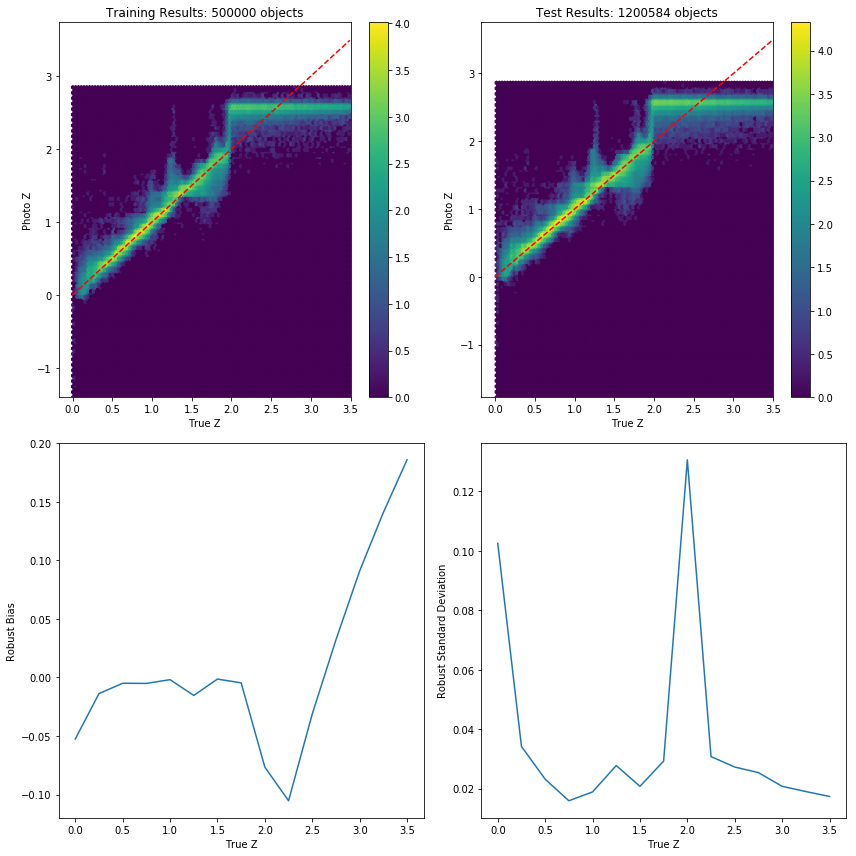

In [44]:
# full
cat_string = 'full_buzzard'
plot_pz.plot_single_results(train_results_dict[cat_string], test_results_dict[cat_string],
                            '../data/%s_results.pdf' % cat_string)

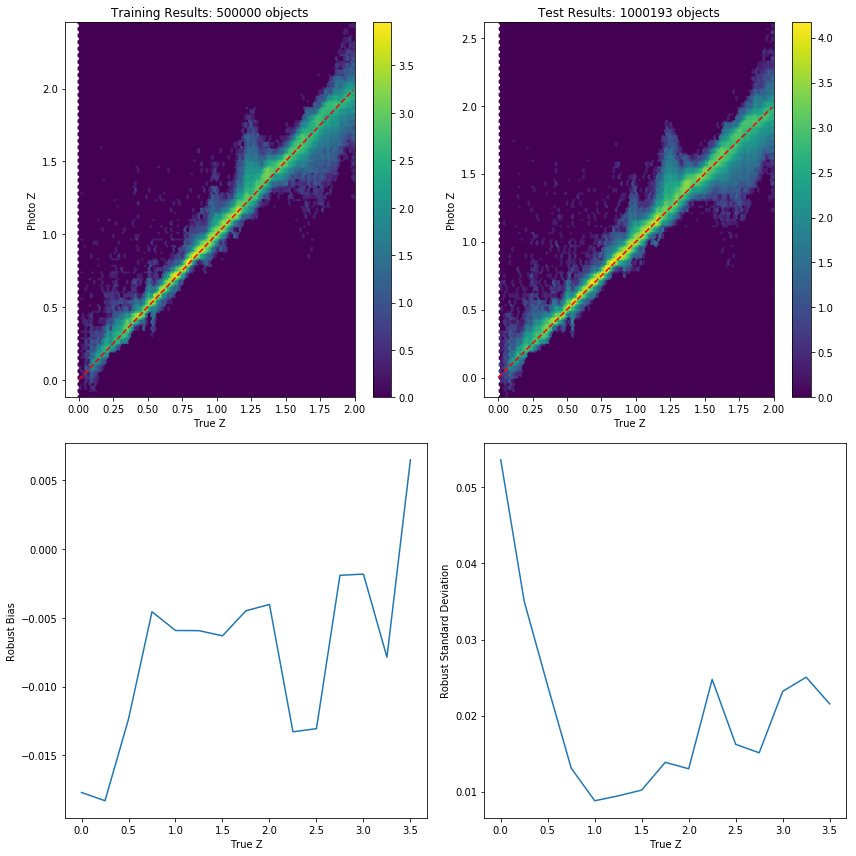

In [53]:
# full
cat_string = 'full_buzzard'
plot_pz.plot_single_results(train_results_dict[cat_string], test_results_dict[cat_string],
                            '../data/%s_results.pdf' % cat_string, z_high=2.)

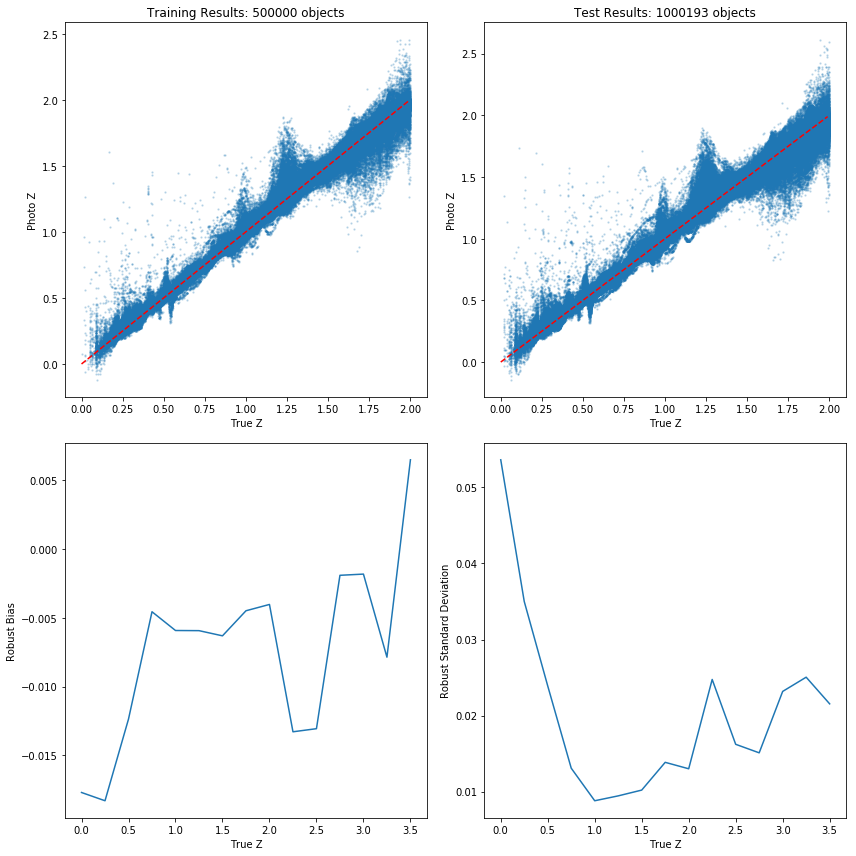

In [57]:
# full
cat_string = 'full_buzzard'
plot_pz.plot_single_results(train_results_dict[cat_string], test_results_dict[cat_string],
                            '../data/%s_results.pdf' % cat_string, z_high=2., density_plot=False)

/epyc/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:4676: RuntimeWarning: overflow encountered in log10
  accum = np.log10(accum + 1)
/epyc/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:4676: RuntimeWarning: invalid value encountered in log10
  accum = np.log10(accum + 1)


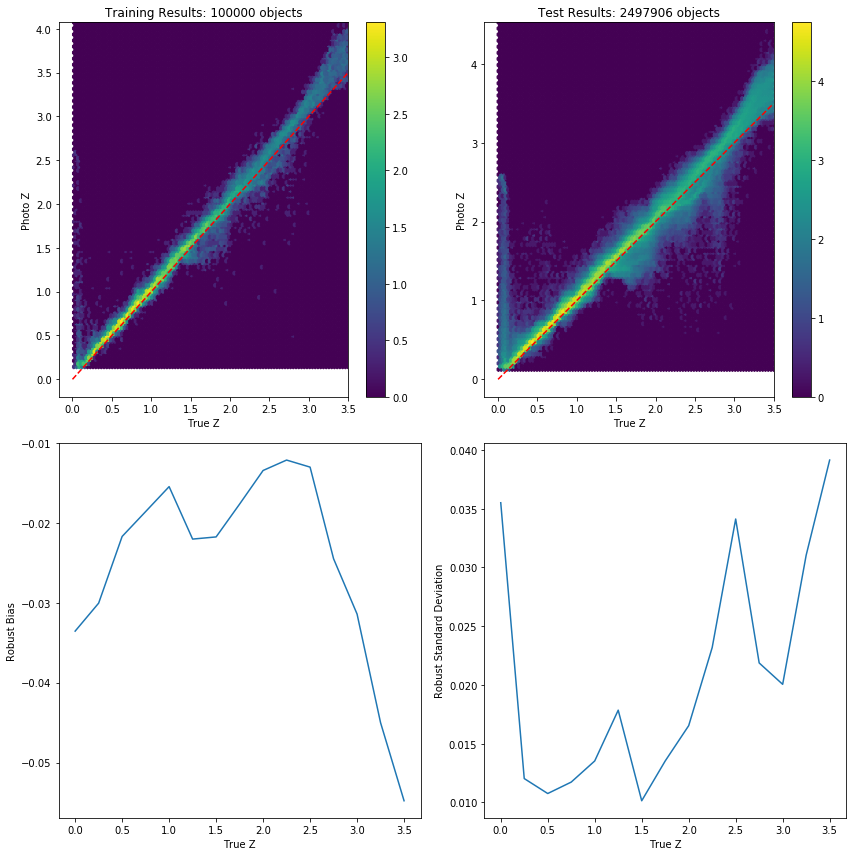

In [20]:
# sparse
cat_string = 'sparse'
plot_pz.plot_single_results(train_results_dict[cat_string], test_results_dict[cat_string],
                            '../data/%s_results.pdf' % cat_string)

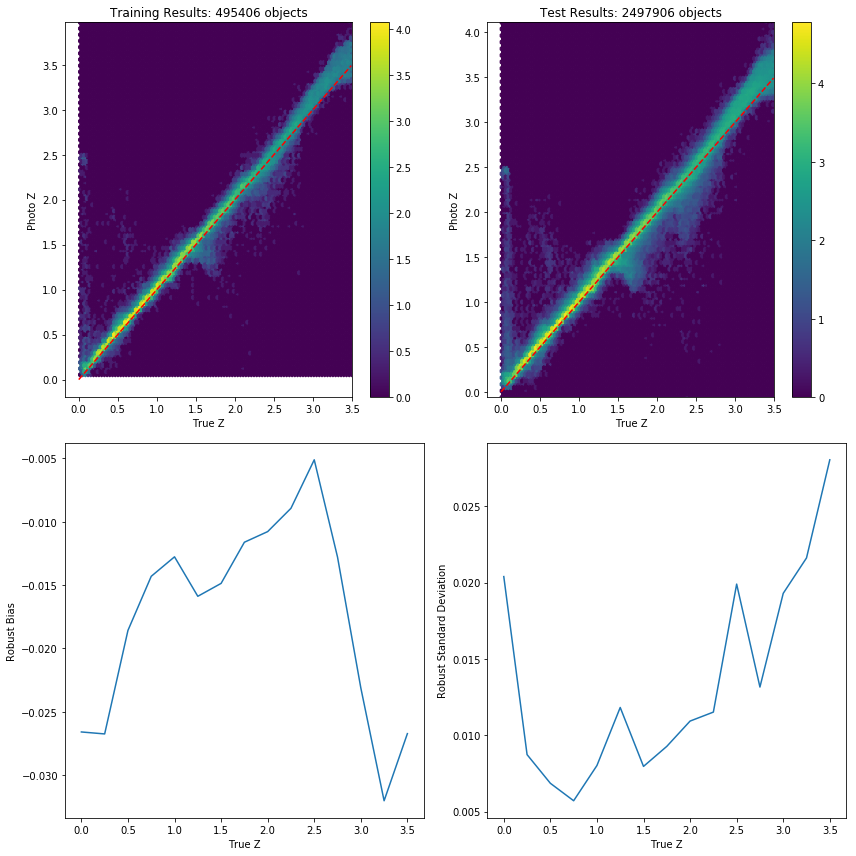

In [21]:
# ug_color_cut
cat_string = 'ug_color_cut'
plot_pz.plot_single_results(train_results_dict[cat_string], test_results_dict[cat_string],
                            '../data/%s_results.pdf' % cat_string)

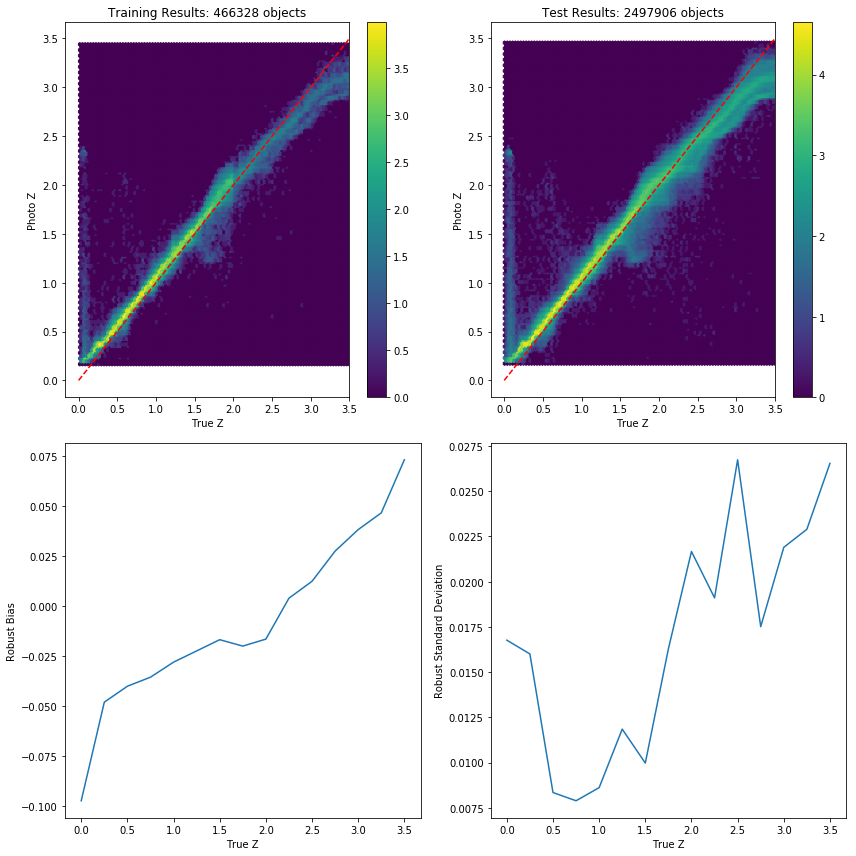

In [22]:
# z_2_cut
cat_string = 'z_2_cut'
plot_pz.plot_single_results(train_results_dict[cat_string], test_results_dict[cat_string],
                            '../data/%s_results.pdf' % cat_string)

### Compare Results

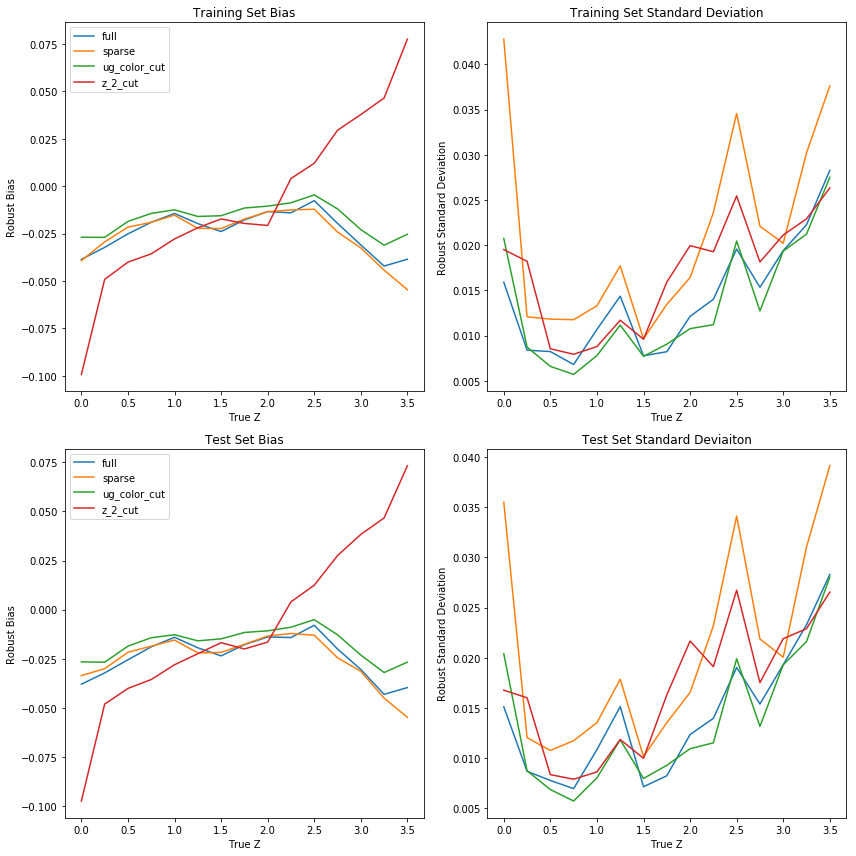

In [27]:
plot_pz.plot_multiple_results(list(train_results_dict.values()),
                              list(test_results_dict.values()),
                              list(train_results_dict.keys()),
                              '../data/compare_all.pdf')

#### Find regions where results are missing and compare

In [46]:
import numpy as np
# Redshift comparison
test_full_df_redshift_cut = test_results_dict['full'].query('true_z > 2').reset_index(drop=True)
test_redshift_df = test_results_dict['z_2_cut'].query('true_z > 2').reset_index(drop=True)


# Load color labels
color_labels = np.genfromtxt('../data/test_labels_ug_color_cut.dat')
test_full_df_color_cut = test_results_dict['full'].iloc[np.where(color_labels == 1.)].reset_index(drop=True)
test_colors_df = test_results_dict['ug_color_cut'].iloc[np.where(color_labels == 1.)].reset_index(drop=True)

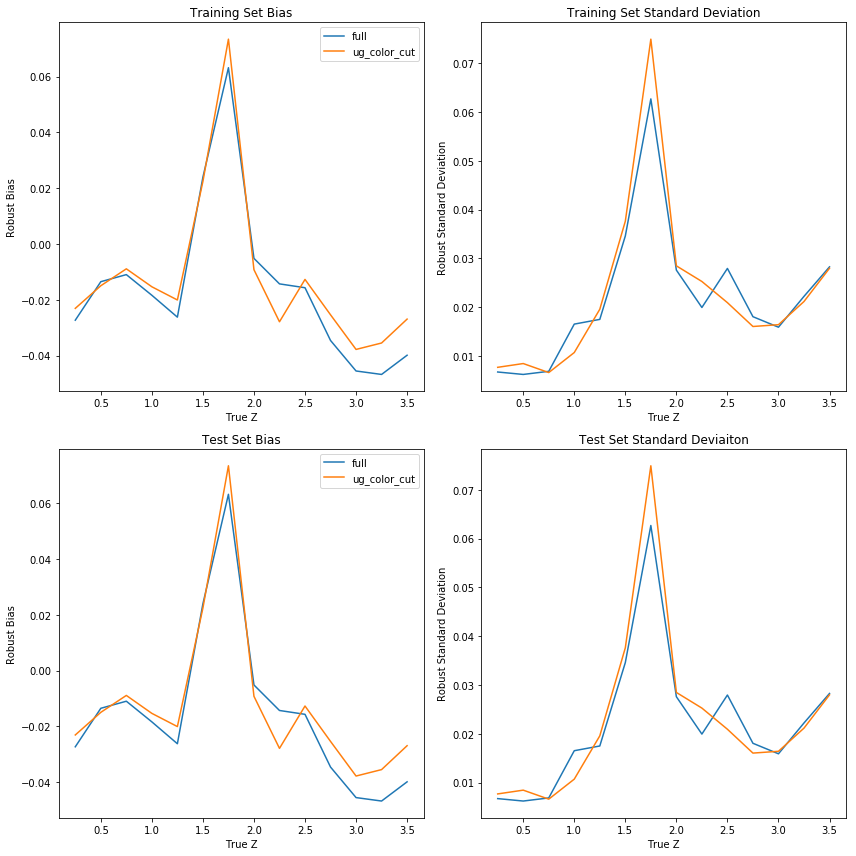

In [44]:
plot_pz.plot_multiple_results([test_full_df_color_cut, test_colors_df],
                              [test_full_df_color_cut, test_colors_df],
                              ['full', 'ug_color_cut'],
                              '../data/compare_color_cut.pdf')

In [11]:
plot_pz.plot_multiple_results([test_full_df_redshift_cut, test_redshift_df],
                              [test_full_df_redshift_cut, test_redshift_df],
                              ['full', 'z_2_cut'],
                              '../data/compare_redshift_cut.pdf')

NameError: name 'test_full_df_redshift_cut' is not defined